In [1]:
from simulator_brian import create_connection_matrix
import os
import imp
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
%load_ext autoreload
%autoreload 2
import pickle as pkl
from brian2 import *
import pdb
import sys
import pandas as pd

In [2]:
data_path = '/home/jovyan/work/instrumentalVariable/test_data_sim_big/'
param_module = 'params_test_big_brian2.py'
os.makedirs(data_path, exist_ok=True)
jobname = param_module.replace('.py', '')
currdir = '/home/jovyan/work/instrumentalVariable/causal-optogenetics-paper-data/'
f, p, d = imp.find_module(jobname, [currdir])
p = imp.load_module(jobname, f, p, d).parameters

### Set neurons


In [3]:
eqs = '''dV_m/dt = (g_L*(E_L-V_m)+Ie+Ii+I+Ix)/(C_m) : volt
         Ie = ge*(E_ex-V_m) : amp
         Ii = gi*(E_in-V_m) : amp
         dge/dt = -ge/(tau_syn_ex) : siemens
         dgi/dt = -gi/(tau_syn_in) : siemens
         Ix = sizes*0.5*(1+sin(2*pi*rates*t)) : amp
         rates : Hz
         sizes : amp
         I : amp'''
nodes = NeuronGroup(
    p['N_neurons'],
    model=eqs,
    threshold='V_m > V_th',
    reset='V_m = V_reset',
    refractory=p['t_ref'],
    namespace=p,
    method='euler',
)

nodes.sizes = p['s_sin']
nodes.rates= p['r_sin']

p['C_ex'] = int(p['eps'] * p['N_ex'])
p['C_in'] = int(p['eps'] * p['N_in'])
n = p['tau_syn_in'] * abs(p['E_L'] - p['E_in'])
d = p['J_ex'] * p['tau_syn_ex'] * abs(p['E_L'] - p['E_ex'])
p['J_in'] = p['g'] * d / n

nodes_ex = nodes[:p['N_ex']]
nodes_in = nodes[p['N_ex']:]

nodes_ex_stim = nodes_ex[:p['stim_N_ex']]

### Set connections from matrix

In [4]:
m = create_connection_matrix(p, p['msd'])

# store connections
with open(str(data_path)+'/'+'m.pkl', 'wb') as f:
            pkl.dump(m, f)

  5%|▌         | 206/4000 [00:00<00:01, 2056.18it/s]

Finding excitatory and inhibitory projections
J_ex =  0.68 nS C_ex =  320 J_in =  12.852 nS C_in =  80


100%|██████████| 4000/4000 [00:01<00:00, 2171.80it/s]


In [5]:
syn_ex = Synapses(
    nodes_ex,
    nodes,
    model='w:siemens',
    on_pre='ge+=w',
    delay=p['syn_delay'])

syn_in = Synapses(
    nodes_in,
    nodes,
    model='w:siemens',
    on_pre='gi+=w',
    delay=p['syn_delay'])

N_ex = p['N_ex']
j, i = np.where(m)
j_ex, i_ex = j[i<N_ex], i[i<N_ex]
j_in, i_in = j[i>=N_ex], i[i>=N_ex]       

syn_ex.connect(i=i_ex, j=j_ex)
syn_ex.w = m[j_ex, i_ex]

syn_in.connect(i=i_in-N_ex, j=j_in)
syn_in.w = m[j_in, i_in]

### Set background stimulation

In [6]:
poissInp = PoissonInput(
    nodes, 'ge',
    N=p['N_p'],
    rate=p['rate_p'],
    weight=p['J_ex'])

### Set spike monitors

In [7]:
# 1 for times without stim
spk_mon1 = SpikeMonitor(nodes)

# 2 for stimulation periods
spk_mon2 = SpikeMonitor(nodes)
spk_mon2.active = False

# population rate monitor
r_mon = PopulationRateMonitor(nodes_ex)

### Simulate

In [8]:
#nodes_ex_stim_i = np.array(nodes_ex_stim.i)

# find last index +1 of stim supgroup
idx_stop_pl_1 = nodes_ex_stim.stop
# make sure that stim subgroups starts with 0
assert nodes_ex_stim.start == 0


@network_operation(when='end')
def stop_for_spikes():
#    if len(nodes_ex_stim.spikes):
#    if len(np.in1d(nodes.spikes, nodes_ex_stim_i)):
    # .spikes is not subgroup specific
    # therefore we have to manually check whether any of the occuring spikes
    # is from the subgroup.
    if len(nodes.spikes) and np.searchsorted(nodes.spikes, idx_stop_pl_1)>0:
        stop()

In [9]:
# run init time without stimulation
stop_for_spikes.active = False
run(p['init_simtime'])
sys.stdout.write('\r'+str(defaultclock.t/ms))
t2 = defaultclock.t/ms

500.0

In [10]:
t1, i1 = np.array(spk_mon1.t), np.array(spk_mon1.i)
r = r_mon.smooth_rate(width=10*ms)

(0, 20)

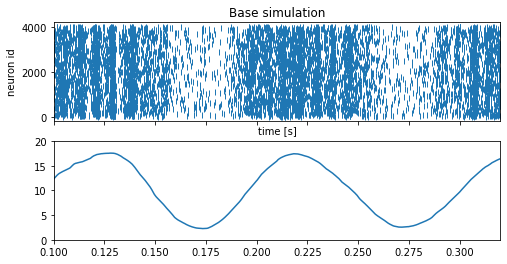

In [11]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8,4))
ax[0].plot(spk_mon1.t/second, spk_mon1.i, '|')
ax[0].set_title('Base simulation')
ax[0].set_xlabel('time [s]')
ax[0].set_ylabel('neuron id')

ax[0].set_xlim(0.1, 0.32)

ax[1].plot(np.arange(0*ms, defaultclock.t, defaultclock.dt), r)
ax[1].set_ylim([0, 20])

(0.0, 20)

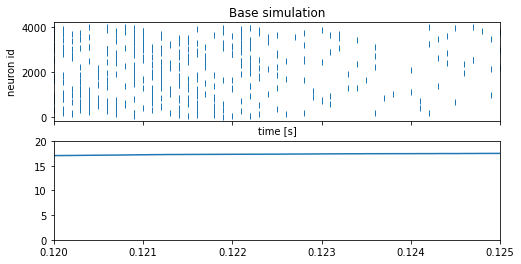

In [12]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8,4))
ax[0].plot(spk_mon1.t/second, spk_mon1.i, '|')
ax[0].set_title('Base simulation')
ax[0].set_xlabel('time [s]')
ax[0].set_ylabel('neuron id')

ax[0].set_xlim(0.12, 0.125)

ax[1].plot(np.arange(0*ms, defaultclock.t, defaultclock.dt), r)
ax[1].set_ylim([0., 20])

In [13]:
# now with stimulation
stop_for_spikes.active = True

# initialize random dealy time between branching points
t_dist_i = np.random.uniform(p['t_dist_min']/ms, p['t_dist_max']/ms)

run(p['runtime'] - defaultclock.t)

while defaultclock.t < p['runtime']:
    if defaultclock.t/ms - t2 > t_dist_i:
        # stimulation only after init_simtime 
        stop_for_spikes.active = False
        # get timepoint of branching, shift by the delay of 0.1 ms
        t2 = defaultclock.t/ms - 0.1
        # store network state before stimulation
        store()
        # We'll need an explicit seed here, otherwise we'll continue with different
        # random numbers after the restore
        use_seed = randint(iinfo(np.int32).max)
        seed(use_seed)
        # change spike monitors
        spk_mon1.active = False
        spk_mon2.active = True
        # stimulate
        nodes_ex_stim.I = p['stim_amp_ex']
        run(p['stim_duration'])
        # turn stimuli off, but keep on simulation
        t_left = p['simtime_stim'] - p['stim_duration']
        nodes_ex_stim.I = 0.*pA
        run(t_left)
        # store data of intermittent run
        spk_mon2_t = np.array(spk_mon2.t/ms)
        spk_mon2_i = np.array(spk_mon2.i).astype(int)
        data = {
            't': t2,
            'spk_ids': spk_mon2_i,
            'spk_ts': spk_mon2_t}
        np.savez(data_path + 'stimulation_data_{}.npz'.format(str(int(t2*10))), data=data)

        # restore previous network state and continue with simulation
        stop_for_spikes.active = True
        restore()
        seed(use_seed)
        spk_mon1.active = True
        spk_mon2.active = False
        with open(data_path + 'log', 'w') as f:
            f.write(str(defaultclock.t/ms))
        sys.stdout.write('\r'+str(defaultclock.t/ms))
        
        # generate waiting time
        t_dist_i = np.random.uniform(p['t_dist_min']/ms, p['t_dist_max']/ms)
    run(p['runtime'] - defaultclock.t)

1151.3999999999999

KeyboardInterrupt: 

### Store spikes

In [ ]:
t1, i1 = np.array(spk_mon1.t), np.array(spk_mon1.i)
with open(str(data_path) + '/' + 'spks1.csv', 'w') as f:
        pd.DataFrame({'t': t1, 'id': i1.astype(int)}
        ).to_csv(f, header=False, index=False)

In [14]:
from causal_optoconnectics.cch import histogram

ModuleNotFoundError: No module named 'causal_optoconnectics'

In [16]:
def correlogram(t1, t2=None, bin_size=.001, limit=.02, auto=False,
                density=False):
    """Calculate cross correlation histogram of two spike trains.
    Essentially, this algorithm subtracts each spike time in `t1`
    from all of `t2` and bins the results with np.histogram, though
    several tweaks were made for efficiency.
    Originally authored by Chris Rodger, copied from OpenElectrophy, licenced
    with CeCill-B.
    Parameters
    ---------
    t1 : np.array
        First spiketrain, raw spike times in seconds.
    t2 : np.array
        Second spiketrain, raw spike times in seconds.
    bin_size : float
        Width of each bar in histogram in seconds.
    limit : float
        Positive and negative extent of histogram, in seconds.
    auto : bool
        If True, then returns autocorrelogram of `t1` and in
        this case `t2` can be None. Default is False.
    density : bool
        If True, then returns the probability density function.
    See also
    --------
    :func:`numpy.histogram` : The histogram function in use.
    Returns
    -------
    (count, bins) : tuple
        A tuple containing the bin right edges and the
        count/density of spikes in each bin.
    Note
    ----
    `bins` are relative to `t1`. That is, if `t1` leads `t2`, then
    `count` will peak in a positive time bin.
    Examples
    --------
    >>> t1 = np.arange(0, .5, .1)
    >>> t2 = np.arange(0.1, .6, .1)
    >>> limit = 1
    >>> bin_size = .1
    >>> counts, bins = correlogram(t1=t1, t2=t2, bin_size=bin_size,
    ...                            limit=limit, auto=False)
    """
    if auto: t2 = t1
    # For auto-CCGs, make sure we use the same exact values
    # Otherwise numerical issues may arise when we compensate for zeros later
    if not int(limit * 1e10) % int(bin_size * 1e10) == 0:
        raise ValueError(
            'Time limit {} must be a '.format(limit) +
            'multiple of bin_size {}'.format(bin_size) +
            ' remainder = {}'.format(limit % bin_size))
    # For efficiency, `t1` should be no longer than `t2`
    swap_args = False
    if len(t1) > len(t2):
        swap_args = True
        t1, t2 = t2, t1

    # Sort both arguments (this takes negligible time)
    t1 = np.sort(t1)
    t2 = np.sort(t2)

    # Determine the bin edges for the histogram
    # Later we will rely on the symmetry of `bins` for undoing `swap_args`
    limit = float(limit)

    # The numpy.arange method overshoots slightly the edges i.e. bin_size + epsilon
    # which leads to inclusion of spikes falling on edges.
    bins = np.arange(-limit, limit + bin_size, bin_size)

    # Determine the indexes into `t2` that are relevant for each spike in `t1`
    ii2 = np.searchsorted(t2, t1 - limit)
    jj2 = np.searchsorted(t2, t1 + limit)

    # Concatenate the recentered spike times into a big array
    # We have excluded spikes outside of the histogram range to limit
    # memory use here.
    big = np.concatenate([t2[i:j] - t for t, i, j in zip(t1, ii2, jj2)])

    # Actually do the histogram. Note that calls to np.histogram are
    # expensive because it does not assume sorted data. Therefore we use
    # the local histogram function
    count, bins = histogram(big, bins=bins, density=density)

    if auto:
        # Compensate for the peak at time zero that results in autocorrelations
        # by subtracting the total number of spikes from that bin. Note
        # possible numerical issue here because 0.0 may fall at a bin edge.
        c_temp, bins_temp = np.histogram([0.], bins=bins)
        bin_containing_zero = np.nonzero(c_temp)[0][0]
        count[bin_containing_zero] = 0#-= len(t1)

    # Finally compensate for the swapping of t1 and t2
    if swap_args:
        # Here we rely on being able to simply reverse `counts`. This is only
        # possible because of the way `bins` was defined (bins = -bins[::-1])
        count = count[::-1]

    return count, bins

In [ ]:
for i in range(1000):
    t_i = t
    t1, i1